In [3]:
    # This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
       for filename in filenames:
            print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [85]:
from datasets import list_datasets , load_dataset
from sklearn.metrics import accuracy_score , f1_score
import matplotlib.pyplot as plt
import torch
from transformers import Trainer , TrainingArguments , pipeline
from transformers import AutoTokenizer,AutoModel,AutoModelForSequenceClassification
from huggingface_hub import notebook_login

In [6]:
notebook_login()

In [7]:
emotions = load_dataset("dair-ai/emotion")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/dair-ai___emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
emotions["train"].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [9]:
emotions.set_format("pandas")

In [10]:
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [11]:
def label_itn2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_itn2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


<Axes: >

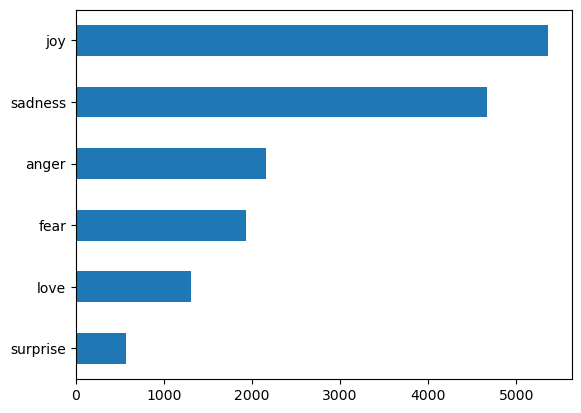

In [12]:
df["label_name"].value_counts(ascending=True).plot.barh()

<Axes: >

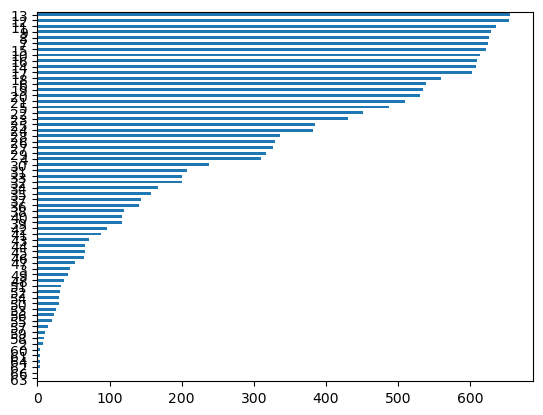

In [13]:
df["words_per_tweet"] = df["text"].str.split().apply(len)
df["words_per_tweet"].value_counts(ascending=True).plot.barh()

In [14]:
emotions.reset_format()

In [15]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)


In [16]:
token2idx = { ch:idx for idx,ch in  enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


In [17]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


In [18]:
input_ids = torch.tensor(input_ids)
one_hot_encodings = torch.nn.functional.one_hot(input_ids,num_classes = len(token2idx))
print(one_hot_encodings.shape)

torch.Size([38, 20])


In [19]:
tokenized_text = text.split()
tokenized_text

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']

In [20]:
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [21]:
encoded_text = tokenizer(text)
encoded_text

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [22]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text["input_ids"])
tokens

['[CLS]',
 'token',
 '##izing',
 'text',
 'is',
 'a',
 'core',
 'task',
 'of',
 'nl',
 '##p',
 '.',
 '[SEP]']

In [23]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [24]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [25]:
def tokenize(batch):
    return tokenizer(batch["text"],padding=True,truncation=True)

print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [26]:
emotions_encoded = emotions.map(tokenize,batched=True,batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [27]:
emotions_encoded["train"]

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 16000
})

In [28]:
num_labels = 6
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels=6)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.

In [65]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels,preds,average="weighted")
    acc = accuracy_score(labels,preds)
    return {"accuracy":acc,"f1":f1}

In [66]:
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{checkpoint}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                    num_train_epochs=2,
                                    learning_rate=2e-5,
                                    per_device_train_batch_size=batch_size,
                                    per_device_eval_batch_size=batch_size,
                                    weight_decay=0.01,
                                    evaluation_strategy="epoch",
                                    disable_tqdm=False,
                                    logging_steps=logging_steps,
                                    push_to_hub=True,
                                    log_level="error",
                                     report_to="none")

In [67]:
trainer = Trainer(model=model, args=training_args,
                    compute_metrics=compute_metrics,
                    train_dataset=emotions_encoded["train"],
                    eval_dataset=emotions_encoded["validation"],
                    tokenizer=tokenizer)


/kaggle/working/distilbert-base-uncased-finetuned-emotion is already a clone of https://huggingface.co/jaswant50/distilbert-base-uncased-finetuned-emotion. Make sure you pull the latest changes with `repo.git_pull()`.


In [68]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.027500,0.292000,0.935500,0.935868
2,0.072000,0.214447,0.933500,0.933621


TrainOutput(global_step=500, training_loss=0.049760626792907714, metrics={'train_runtime': 148.4437, 'train_samples_per_second': 215.57, 'train_steps_per_second': 3.368, 'total_flos': 720342861696000.0, 'train_loss': 0.049760626792907714, 'epoch': 2.0})

In [69]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [73]:
preds_output.metrics

{'test_loss': 0.21444684267044067,
 'test_accuracy': 0.9335,
 'test_f1': 0.9336214774727247,
 'test_runtime': 2.7954,
 'test_samples_per_second': 715.458,
 'test_steps_per_second': 11.447}

In [80]:
y_preds = np.argmax(preds_output.predictions,axis=1)

In [82]:
trainer.push_to_hub(commit_message="Training Completed")

To https://huggingface.co/jaswant50/distilbert-base-uncased-finetuned-emotion
   165906d..9ed424d  main -> main



In [83]:
model_id = "jaswant50/distilbert-base-uncased-finetuned-emotion"

In [89]:
classifier = pipeline("text-classification",model=model_id)

In [99]:
df = pd.DataFrame(classifier("i saw a movie today and it was really good",return_all_scores=True)[0])

/opt/conda/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [100]:
labels = ["sadness","joy","love","anger","fear","surprise"]

<BarContainer object of 6 artists>

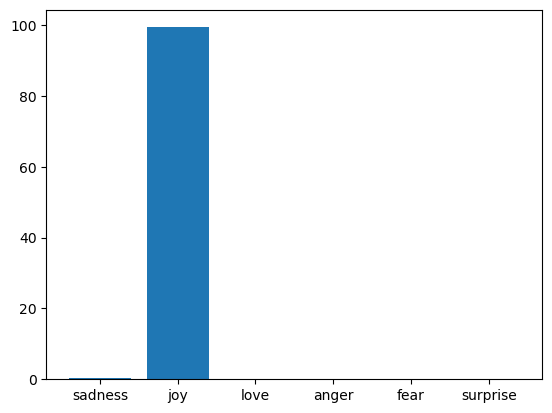

In [101]:
plt.bar(labels,df["score"]*100)